##Instalaciones

In [4]:
pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 131.4 MB/s 


In [6]:
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym

In [7]:
import psutil
import time


In [8]:
env_id = "CartPole-v1"
env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


##Reinforce Architecture

In [13]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)       

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

##Algorithm

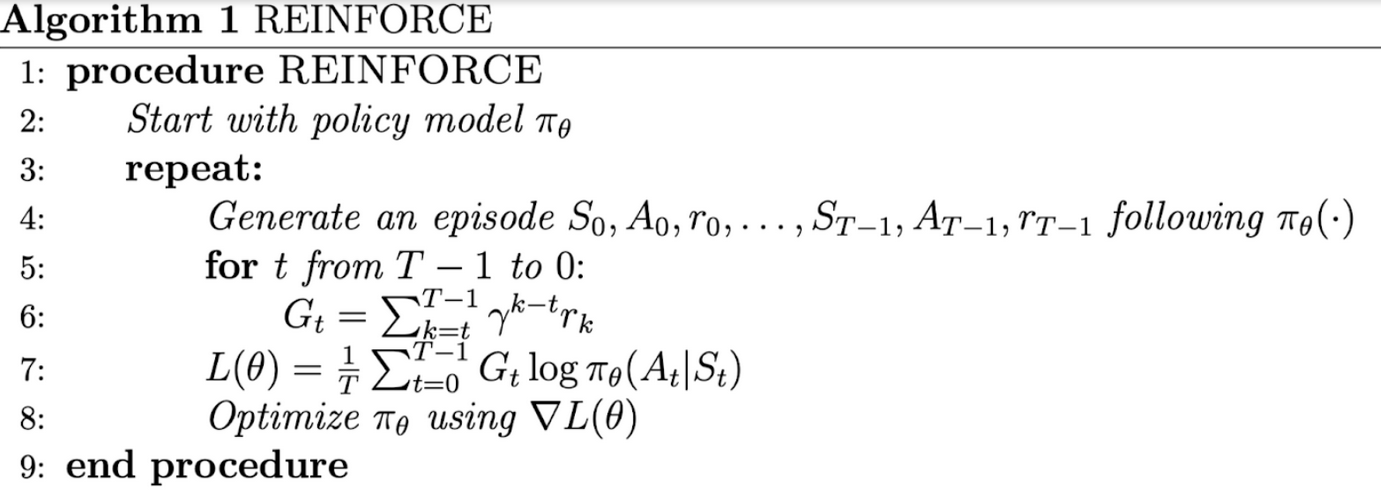

In [10]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    list_time = []
    list_score = []
    #Calcular la puntuación durante el entrenamiento
    scores_deque = deque(maxlen=100)
    scores = []
    time_episode_deque = deque(maxlen=100)
    #Linea 3
    for i_episode in range(1, n_training_episodes+1):
        start_time_episode = time.time()
        saved_log_probs = []
        rewards = []
        state = env.reset()
        #Linea 4
        for t in range(max_t):            
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            #print("valores",state, reward, done, _ )            
            rewards.append(reward)
            if done:
              break         
        time_episode = time.time() - start_time_episode
        time_episode_deque.append(time_episode)
        #Importante: comentado el tiempo por episodio para no llenar los resultados de colab. Si desea ver el tiempo por episodio debe de descomentar la linea de abajo.
        #print("Episodio",i_episode, "-> %s seg por episodio" % (time_episode))
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        #Linea 6
        #Se calcula los descuentos, por ejemplo [0.99^1, 0.99^2, 0.99^3, ..., 0.99^len(rewards)]
        discounts = [gamma**i for i in range(len(rewards)+1)]
        #Se calcula sum(gamma[t] * reward[t]) 
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        #Linea 7
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        #Linea  8
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()  
        if i_episode % print_every == 0:
          print("--Episodio:", i_episode,"--")
          print('Episodio {}\tPromedio seg: {:.4f}'.format(i_episode, np.mean(time_episode_deque)))                     
          print('Memoria en MB usado hasta el momento:',psutil.Process().memory_info().rss / (1024 * 1024))           
          print('Episodio {}\tPuntuacion media: {:.2f}'.format(i_episode, np.mean(scores_deque)))          
          list_time.append(np.mean(time_episode_deque))
          list_score.append(np.mean(scores_deque))

    return [list_time,list_score]

##Entrenamiento(1000 episodios de entrenamineto):


In [205]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

Creanado una politica

In [206]:
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"])
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [223]:
res_1k = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"], 
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"], 
                   100)

--Episodio: 100 --
Episodio 100	Promedio seg: 0.0536
Memoria en MB usado hasta el momento: 432.94921875
Episodio 100	Puntuacion media: 138.01
--Episodio: 200 --
Episodio 200	Promedio seg: 0.0802
Memoria en MB usado hasta el momento: 432.94921875
Episodio 200	Puntuacion media: 196.64
--Episodio: 300 --
Episodio 300	Promedio seg: 0.0648
Memoria en MB usado hasta el momento: 432.94921875
Episodio 300	Puntuacion media: 165.73
--Episodio: 400 --
Episodio 400	Promedio seg: 0.0353
Memoria en MB usado hasta el momento: 432.94921875
Episodio 400	Puntuacion media: 91.94
--Episodio: 500 --
Episodio 500	Promedio seg: 0.0535
Memoria en MB usado hasta el momento: 432.94921875
Episodio 500	Puntuacion media: 137.28
--Episodio: 600 --
Episodio 600	Promedio seg: 0.0842
Memoria en MB usado hasta el momento: 432.94921875
Episodio 600	Puntuacion media: 211.77
--Episodio: 700 --
Episodio 700	Promedio seg: 0.0583
Memoria en MB usado hasta el momento: 432.94921875
Episodio 700	Puntuacion media: 140.42
--Episo

##Entrenamiento (10000 episodios de entrenamiento)


In [14]:
cartpole_hyperparameters_10k = {
    "h_size": 16,
    "n_training_episodes": 10000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

Creando una politica

In [16]:
cartpole_policy_10k = Policy(cartpole_hyperparameters_10k["state_space"], cartpole_hyperparameters_10k["action_space"], cartpole_hyperparameters_10k["h_size"])
cartpole_optimizer_10k = optim.Adam(cartpole_policy_10k.parameters(), lr=cartpole_hyperparameters_10k["lr"])

In [17]:
res_10k = reinforce(cartpole_policy_10k,
                   cartpole_optimizer_10k,
                   cartpole_hyperparameters_10k["n_training_episodes"], 
                   cartpole_hyperparameters_10k["max_t"],
                   cartpole_hyperparameters_10k["gamma"], 
                   100)

--Episodio: 100 --
Episodio 100	Promedio seg: 0.0058
Memoria en MB usado hasta el momento: 313.63671875
Episodio 100	Puntuacion media: 16.64
--Episodio: 200 --
Episodio 200	Promedio seg: 0.0039
Memoria en MB usado hasta el momento: 313.60546875
Episodio 200	Puntuacion media: 14.00
--Episodio: 300 --
Episodio 300	Promedio seg: 0.0036
Memoria en MB usado hasta el momento: 313.61328125
Episodio 300	Puntuacion media: 13.30
--Episodio: 400 --
Episodio 400	Promedio seg: 0.0088
Memoria en MB usado hasta el momento: 313.61328125
Episodio 400	Puntuacion media: 32.71
--Episodio: 500 --
Episodio 500	Promedio seg: 0.0107
Memoria en MB usado hasta el momento: 313.61328125
Episodio 500	Puntuacion media: 41.57
--Episodio: 600 --
Episodio 600	Promedio seg: 0.0119
Memoria en MB usado hasta el momento: 313.61328125
Episodio 600	Puntuacion media: 44.96
--Episodio: 700 --
Episodio 700	Promedio seg: 0.0154
Memoria en MB usado hasta el momento: 313.8671875
Episodio 700	Puntuacion media: 58.06
--Episodio: 80

#Graficos

In [18]:
from matplotlib import pyplot as plt

##Ejecutar el entrenamiento de 1k antes de continuar

###(Segundos) promedio por cada 100 episodios consecutivos de entrenamiento

> Bloque con sangría



In [224]:
res_1k[0]

[0.053558928966522215,
 0.08024756669998169,
 0.06480645179748536,
 0.035294549465179445,
 0.053542346954345704,
 0.08424617290496826,
 0.05833884000778198,
 0.06958264589309693,
 0.05725529670715332,
 0.09195799589157104]

In [237]:
res_1k[1]

[138.01, 196.64, 165.73, 91.94, 137.28, 211.77, 140.42, 176.47, 151.01, 231.94]

In [22]:
def plot_time(datos, n):
  plt.plot(range(100,n+1,100), [round(item, 4) for item in datos])
  plt.ylabel("Promedio 100 episodios consecutivos(segundos)")
  plt.xlabel("Episodio")

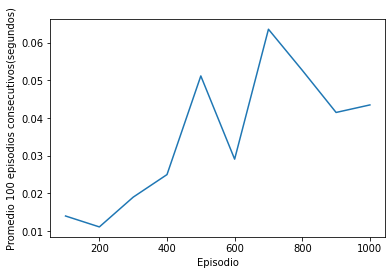

In [239]:
plot_time(res[0], 1000)

###Score promedio por cada 100 episodios consecutivos de entrenamiento

In [23]:
def plot_score(datos, n):
  plt.plot(range(100,n+1,100), [round(item, 4) for item in datos])
  plt.ylabel("Promedio 100 episodios consecutivos(puntaje)")
  plt.xlabel("Episodio")

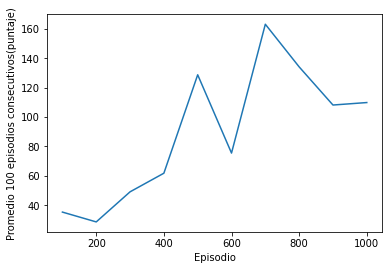

In [241]:
plot_score(res[1], 1000)

##Ejecutar el entrenamiento de 10k antes de continuar

In [19]:
res_10k[0]

[0.005760288238525391,
 0.003930273056030273,
 0.0035686159133911134,
 0.00879319667816162,
 0.010692243576049804,
 0.011904921531677246,
 0.015416741371154785,
 0.01792775869369507,
 0.016901867389678957,
 0.02219418525695801,
 0.02158154010772705,
 0.020348258018493652,
 0.01314849853515625,
 0.015015594959259033,
 0.035887103080749515,
 0.03797703266143799,
 0.015575602054595947,
 0.0207715106010437,
 0.03046678066253662,
 0.025495808124542236,
 0.030852811336517336,
 0.06744733572006226,
 0.031164283752441405,
 0.03227843999862671,
 0.03995136260986328,
 0.032532758712768554,
 0.0648932957649231,
 0.037206976413726806,
 0.054923574924469,
 0.06830767154693604,
 0.03585022687911987,
 0.03371807098388672,
 0.03306913137435913,
 0.05519976615905762,
 0.053124687671661376,
 0.0307777738571167,
 0.03723318576812744,
 0.03391695261001587,
 0.038877034187316896,
 0.03793307065963745,
 0.03398619174957276,
 0.040478641986846926,
 0.04358656644821167,
 0.039897868633270266,
 0.0492297482490

In [20]:
res_10k[1]

[16.64,
 14.0,
 13.3,
 32.71,
 41.57,
 44.96,
 58.06,
 66.7,
 62.05,
 82.89,
 79.95,
 73.43,
 47.96,
 54.75,
 124.94,
 140.59,
 56.48,
 69.01,
 109.77,
 92.4,
 112.65,
 245.95,
 109.01,
 118.43,
 149.69,
 119.27,
 238.54,
 139.77,
 204.65,
 256.86,
 130.98,
 125.56,
 118.8,
 203.08,
 194.72,
 112.6,
 135.14,
 123.39,
 137.12,
 136.44,
 123.85,
 148.68,
 156.51,
 146.27,
 179.51,
 137.34,
 73.65,
 85.73,
 115.75,
 356.35,
 449.08,
 151.99,
 437.2,
 315.07,
 255.99,
 307.75,
 500.0,
 287.37,
 239.28,
 260.15,
 204.95,
 190.93,
 205.62,
 175.05,
 169.22,
 186.3,
 185.57,
 206.75,
 239.46,
 239.39,
 236.92,
 308.54,
 258.33,
 375.74,
 500.0,
 500.0,
 500.0,
 500.0,
 435.37,
 181.34,
 437.07,
 446.57,
 494.54,
 483.73,
 476.8,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0,
 500.0]

###(Segundos) promedio por cada 100 episodios consecutivos de entrenamiento

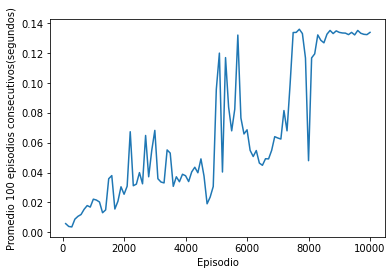

In [24]:
plot_time(res_10k[0], 10000)

###Score promedio por cada 100 episodios consecutivos de entrenamiento

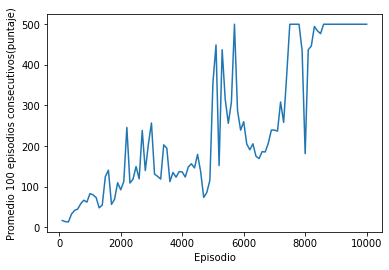

In [25]:
plot_score(res_10k[1], 10000)